# Análise Exploratória de Dados

## 0. Setup

**Importações**

In [28]:
import os, random
import pandas as pd, numpy as np    # manipulação de dados
import matplotlib.pyplot as plt     # gráficos
import seaborn as sns
from PIL import Image, ImageOps, ImageStat, ImageFilter     # leitura de imagens
from tqdm import tqdm               # barras de progresso
from google.colab import drive
from collections import Counter
import hashlib

from torchvision import transforms

Definição de semente fixa para gerar resultados reproduzíveis

In [5]:
SEED = 42
random.seed(SEED); np.random.seed(SEED)

Definições Visuais

In [6]:
plt.rcParams.update({"figure.dpi": 150, "savefig.dpi": 300})

**Estruturas de Pastas**

- `figures/` → onde os gráficos serão salvos (`.png`)
- `reports/` → para armazenar tabelas, splits e artefatos (`.csv`, `.json`)

In [ ]:
os.makedirs("figures", exist_ok=True)
os.makedirs("reports", exist_ok=True)

**Carregamento do Dataset**

In [3]:
METADATA_PATH = "/content/drive/MyDrive/Colab Notebooks/UFES Pós IA CD/10. TCC/Dataset PAD-UFES-20/"
DATA_PATH = METADATA_PATH + "images/"

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
metadata = pd.read_csv(METADATA_PATH + "metadata.csv")
df = metadata.copy()

In [ ]:
TARGET = "diagnostic"                   # classes
PID, LID = "patient_id", "lesion_id"    # chaves de agrupamento (evitar vazamento entre splits)

### Um Exemplo

In [8]:
metadata

patient_id  lesion_id  smoke  drink background_father background_mother  \
0      PAT_1516       1765    NaN    NaN               NaN               NaN   
1        PAT_46        881  False  False         POMERANIA         POMERANIA   
2      PAT_1545       1867    NaN    NaN               NaN               NaN   
3      PAT_1989       4061    NaN    NaN               NaN               NaN   
4       PAT_684       1302  False   True         POMERANIA         POMERANIA   
...         ...        ...    ...    ...               ...               ...   
2293   PAT_1708       3156    NaN    NaN               NaN               NaN   
2294     PAT_46        880  False  False         POMERANIA         POMERANIA   
2295   PAT_1343       1217    NaN    NaN               NaN               NaN   
2296    PAT_326        690  False  False         POMERANIA         POMERANIA   
2297   PAT_1714       3189    NaN    NaN               NaN               NaN   

      age pesticide  gender skin_cancer_history  ... diameter_2 diagnostic  \
0       8       NaN     NaN                 NaN  ...        NaN        NEV   
1      55     False  FEMALE                True  ...        5.0        BCC   
2      77       NaN     NaN                 NaN  ...        NaN        ACK   
3      75       NaN     NaN                 NaN  ...        NaN        ACK   
4      79     False    MALE                True  ...        5.0        BCC   
...   ...       ...     ...                 ...  ...        ...        ...   
2293   73       NaN     NaN                 NaN  ...        NaN        ACK   
2294   55     False  FEMALE                True  ...       12.0        BCC   
2295   74       NaN     NaN                 NaN  ...        NaN        SEK   
2296   58      True  FEMALE                True  ...        4.0        BCC   
2297   41       NaN     NaN                 NaN  ...        NaN        SEK   

       itch   grew   hurt  changed  bleed elevation                 img_id  \
0     False  False  False    False  False     False  PAT_1516_1765_530.png   
1      True   True  False     True   True      True     PAT_46_881_939.png   
2      True  False  False    False  False     False  PAT_1545_1867_547.png   
3      True  False  False    False  False     False  PAT_1989_4061_934.png   
4      True   True  False    False   True      True   PAT_684_1302_588.png   
...     ...    ...    ...      ...    ...       ...                    ...   
2293   True  False  False    False  False     False  PAT_1708_3156_175.png   
2294   True   True  False     True  False     False     PAT_46_880_140.png   
2295  False  False  False    False  False     False  PAT_1343_1217_404.png   
2296   True  False  False    False  False      True    PAT_326_690_823.png   
2297  False   True  False    False  False      True  PAT_1714_3189_989.png   

     biopsed  
0      False  
1       True  
2      False  
3      False  
4       True  
...      ...  
2293   False  
2294    True  
2295   False  
2296    True  
2297   False  

[2298 rows x 26 columns]

In [9]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2298 entries, 0 to 2297
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   patient_id           2298 non-null   object 
 1   lesion_id            2298 non-null   int64  
 2   smoke                1494 non-null   object 
 3   drink                1494 non-null   object 
 4   background_father    1480 non-null   object 
 5   background_mother    1476 non-null   object 
 6   age                  2298 non-null   int64  
 7   pesticide            1494 non-null   object 
 8   gender               1494 non-null   object 
 9   skin_cancer_history  1494 non-null   object 
 10  cancer_history       1494 non-null   object 
 11  has_piped_water      1494 non-null   object 
 12  has_sewage_system    1494 non-null   object 
 13  fitspatrick          1494 non-null   float64
 14  region               2298 non-null   object 
 15  diameter_1           1494 non-null   f

In [ ]:
image_name = DATA_PATH + metadata.sample(1).img_id.iloc[0]

In [ ]:
image_name

'/content/drive/MyDrive/Colab Notebooks/UFES Pós IA CD/10. TCC/Dataset PAD-UFES-20/images/PAT_1186_680_578.png'

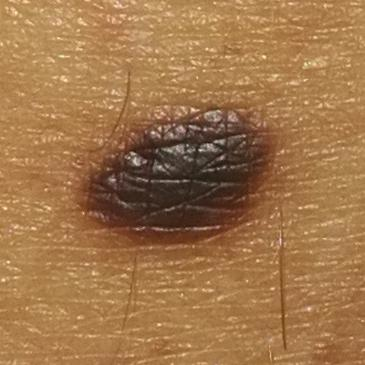

In [ ]:
img = Image.open(image_name)
display(img)

## 1. Entendimento da Variável Alvo

### 1.1. Frequência e Proporção por Classe

#### Proporções por Classe

diagnostic  count  percent
0        BCC    845    36.77
1        ACK    730    31.77
2        NEV    244    10.62
3        SEK    235    10.23
4        SCC    192     8.36
5        MEL     52     2.26

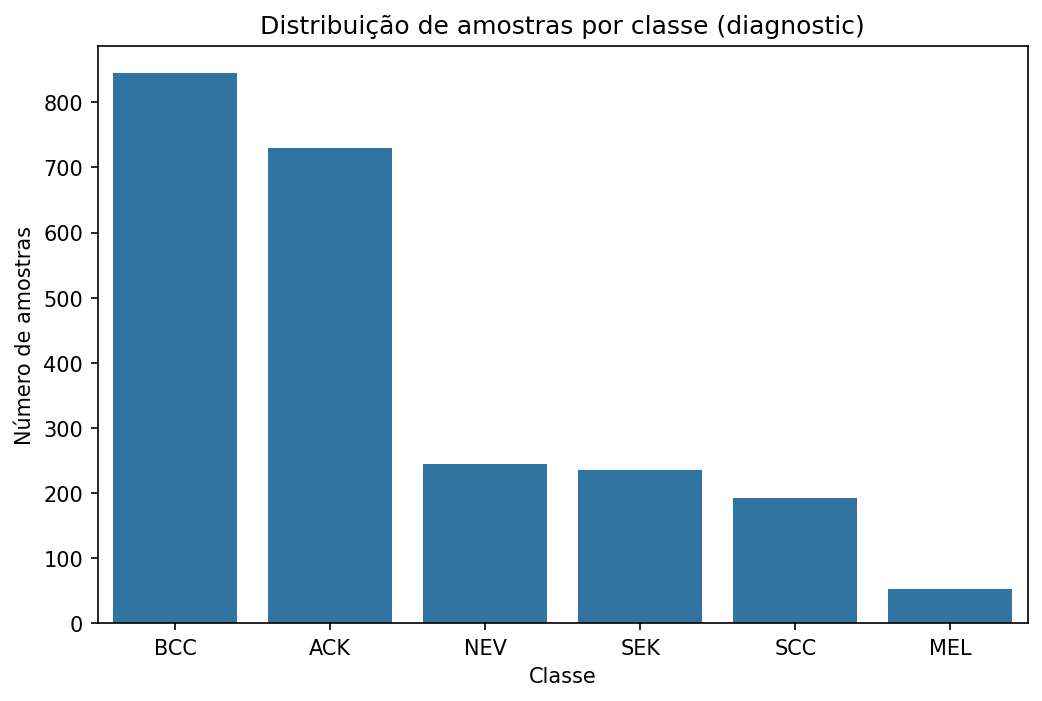

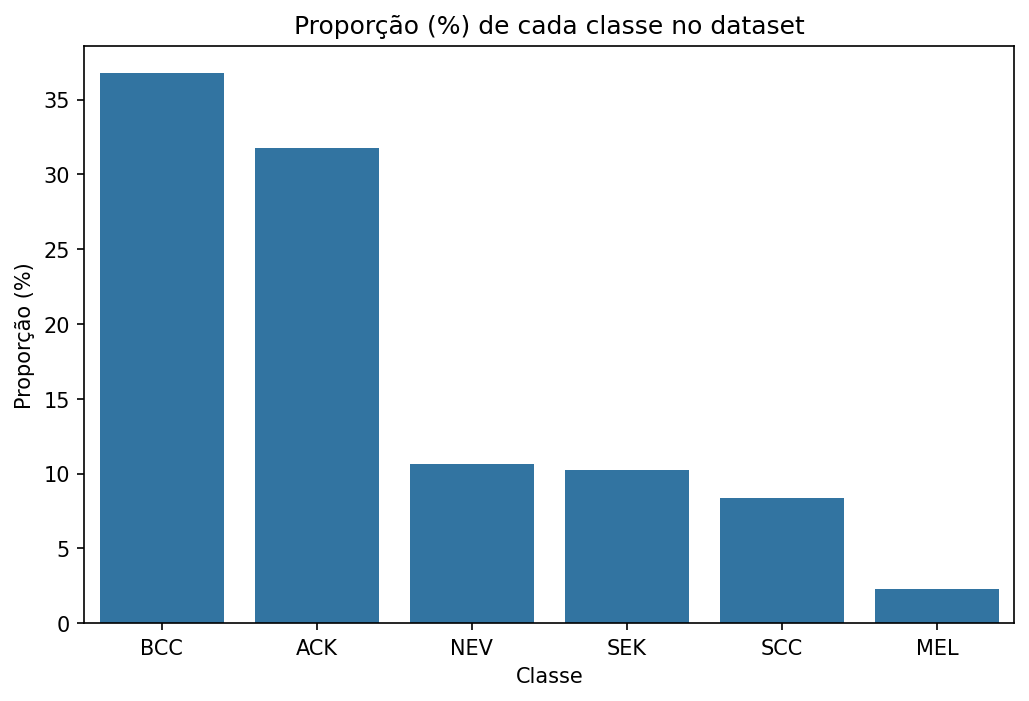

In [10]:
# ler metadados
metadata = pd.read_csv(METADATA_PATH + "metadata.csv")

# cálculo contagem e proporção por classe
class_counts = metadata['diagnostic'].value_counts().reset_index()
class_counts.columns = ['diagnostic', 'count']
class_counts['percent'] = (class_counts['count'] / class_counts['count'].sum() * 100).round(2)

# exibir tabela ordenada
display(class_counts)
print("\n")

# gráfico de barras ordenado
plt.figure(figsize=(8, 5))
sns.barplot(
    data = class_counts,
    x = 'diagnostic',
    y = 'count',
    order = class_counts.sort_values('count', ascending = False)['diagnostic']
)
plt.title("Distribuição de amostras por classe (diagnostic)")
plt.ylabel("Número de amostras")
plt.xlabel("Classe")
plt.show()

# Gráfico de Proporções
plt.figure(figsize=(8, 5))
sns.barplot(
    data = class_counts,
    x = 'diagnostic',
    y = 'percent',
    order = class_counts.sort_values('count', ascending = False)['diagnostic']
)
plt.title("Proporção (%) de cada classe no dataset")
plt.ylabel("Proporção (%)")
plt.xlabel("Classe")
plt.show()

#### Relação Câncer x Doença Maligna

As classes podem ser divididas entre dois grupos: câncer de pele e doenças de pele.

Os cancêr de pele são Basal Cell Carcinoma (BCC), Melanoma (MEL) e Squamous Cell Carcinoma (SCC). E as doenças de pele são Actinic Keratosis (ACK), Nevus (NEV) e Seborrheic Keratosis (SEK).

In [11]:
metadata['diagnostic_group'] = metadata['diagnostic'].apply(
    lambda x: 'Cancer' if x in ['BCC', 'MEL', 'SCC'] else 'Benign'
)
metadata['diagnostic_group'].value_counts(normalize=True).round(3)

diagnostic_group
Benign    0.526
Cancer    0.474
Name: proportion, dtype: float64

A base de dados está praticamente balaceada entre malignos (47,4%) e benignos (52,6%), então o modelo não terá viés estrutural binário. Porém, o desbalanceamento real está intra-grupo.

#### Avaliação de Raridade Extrema (Cauda Longa)

Gráfico de Pareto para acumulação de Amostras

"Cauda longa" é a porção da distribuição de dados que contém muitas ocorrências raras, distantes do ponto central (a "cabeça") da distribuição.

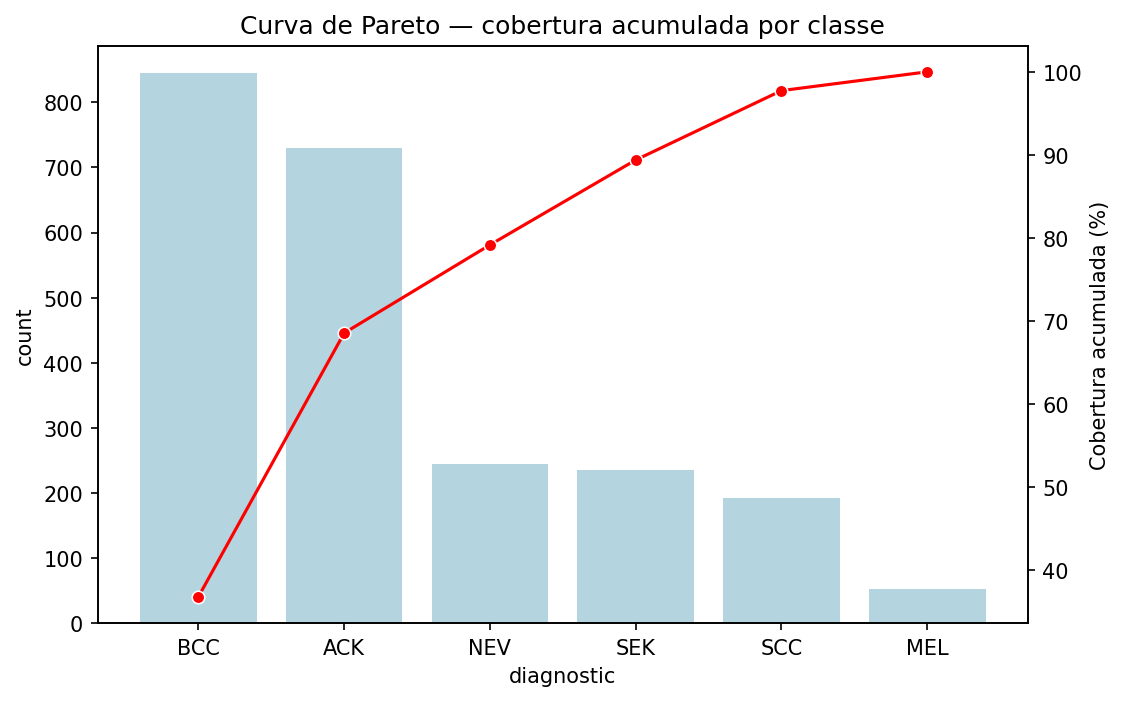

In [12]:
class_counts['cum_percent'] = class_counts['count'].cumsum() / class_counts['count'].sum() * 100
plt.figure(figsize=(8, 5))
sns.barplot(x='diagnostic', y='count', data=class_counts, color='lightblue')
plt.twinx()
sns.lineplot(x='diagnostic', y='cum_percent', data=class_counts, color='red', marker='o')
plt.title("Curva de Pareto — cobertura acumulada por classe")
plt.ylabel("Cobertura acumulada (%)")
plt.show()

As 2 maiores classes (BCC e ACK) somam quase 70% das amostras, havendo um forte desbalanceamento. Enquanto que as classes menores MEL (2%) e SCC (8%) formam a cauda longa que exigirá atenção no treino (ex.: `class_weight`, oversampling)

#### Relação `diagnostic` x `biopsed`



In [13]:
biopsy_check = metadata.groupby('diagnostic')['biopsed'].mean().sort_values(ascending=False)
display(biopsy_check)


diagnostic
BCC    1.000000
MEL    1.000000
SCC    1.000000
NEV    0.245902
ACK    0.243836
SEK    0.063830
Name: biopsed, dtype: float64

 100% das condições malignas validadas por biópsia e cerca de 6-25% das benignas validas.

### 1.2. Amostras por Paciente

num_images  num_lesions
count  1373.000000  1373.000000
mean      1.673707     1.377276
std       1.115038     0.764830
min       1.000000     1.000000
25%       1.000000     1.000000
50%       1.000000     1.000000
75%       2.000000     2.000000
max      10.000000     8.000000

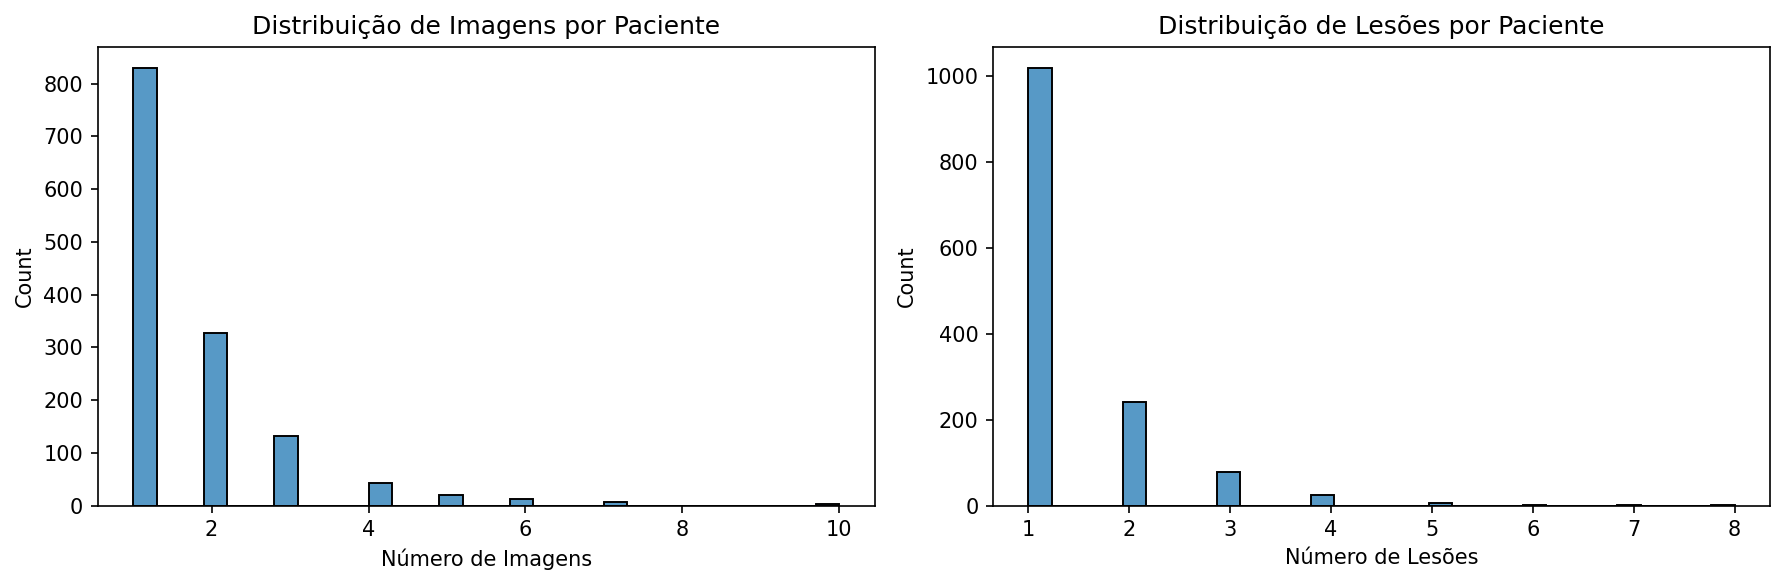


Pacientes com múltiplas imagens da mesma lesão: 361



patient_id  lesion_id  img_id
1     PAT_100        393       2
3    PAT_1006         53       2
5     PAT_101       1041       3
16   PAT_1026        124       2
18   PAT_1029        135       2

In [14]:
# 1 - contar imagens e lesões por paciente
imgs_por_paciente = metadata.groupby('patient_id')['img_id'].nunique()
lesoes_por_paciente = metadata.groupby('patient_id')['lesion_id'].nunique()

# 2 - combinar em um único dataframe
paciente_stats = pd.DataFrame({
    'num_images': imgs_por_paciente,
    'num_lesions': lesoes_por_paciente
}).reset_index()

# 3 - estatísticas
display(paciente_stats.describe())
print("\n")

# 4 - histogramas
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(paciente_stats['num_images'], bins=30, ax=axes[0])
axes[0].set_title('Distribuição de Imagens por Paciente')
axes[0].set_xlabel("Número de Imagens")

sns.histplot(paciente_stats['num_lesions'], bins=30, ax=axes[1])
axes[1].set_title('Distribuição de Lesões por Paciente')
axes[1].set_xlabel("Número de Lesões")

plt.tight_layout()
plt.show()

# 5 - pacientes com múltiplas imagens da mesma lesão
dup_check = metadata.groupby(['patient_id', 'lesion_id'])['img_id'].nunique().reset_index()
dup_check = dup_check[dup_check['img_id'] > 1]
print(f"\nPacientes com múltiplas imagens da mesma lesão: {len(dup_check)}\n")

display(dup_check.head())

**Observações:**

- **1.373 pacientes** (conforme constatado no artigo do PAD-UFES-20).
- **Média** ≈ 1,67 imagens/paciente e 1,38 lesões/paciente.
- **Mediana**: 1 imagem e 1 lesão. A maioria tem um único registro.
- **Cauda longa**: até 10 imagens ou 8 lesões em poucos casos.
- **361 lesões** têm múltiplas imagens (≈ 22% do total de 1.641 lesões). Isso *confirma o risco real de vazamento se o particionamento fosse feito por imagem*.


**Conclusões de 1.2 (Amostras por Paciente):**

O dataset é majoritariamente composto por 1 imagem -> 1 lesão -> 1 paciente, mas há um subcojunto relevante com várias imagens por lesão.

Portanto, o split deve ser por `patient_id`, garantindo que todas as imagens do mesmo paciente fiquem no mesmo conjunto.

### 1.3. Tabela Visual

Com 1 amostra por classe de lesão

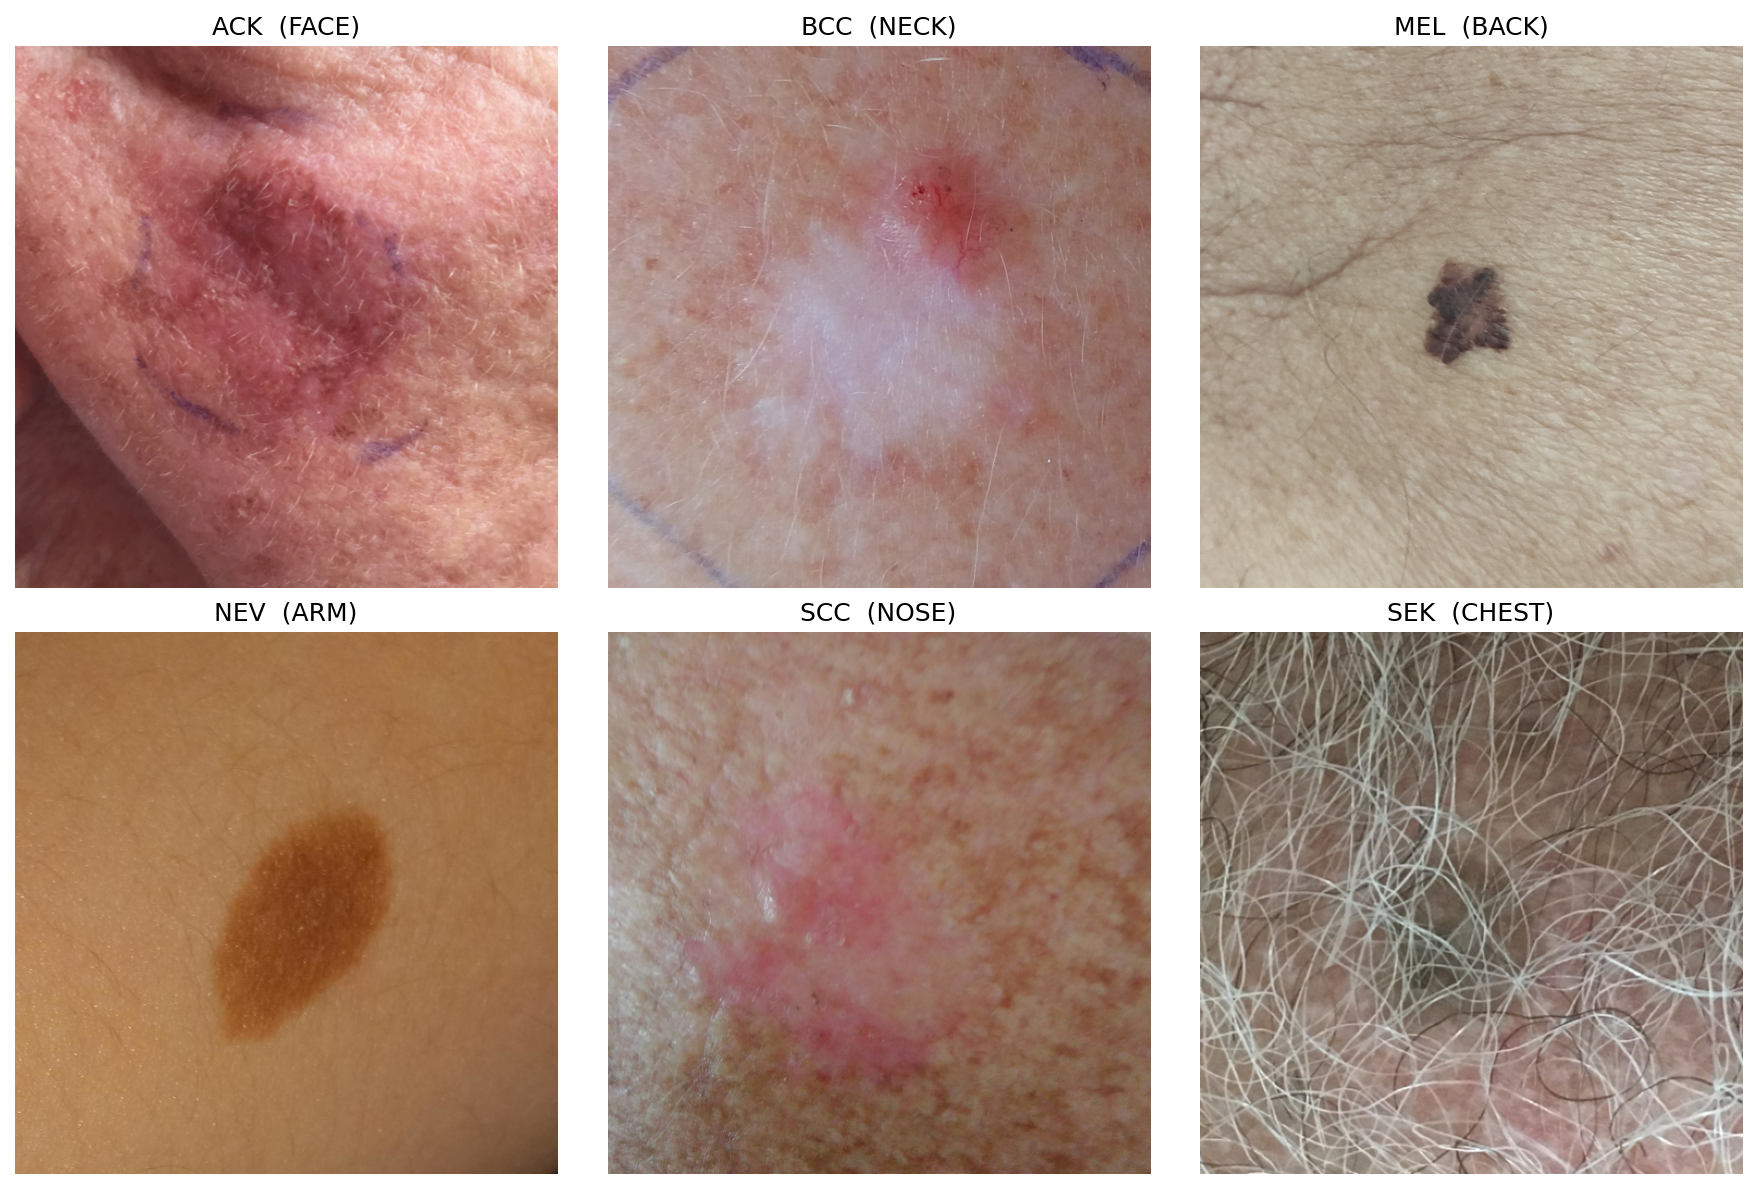

In [15]:
# 1 - selecionar uma amostra represetativa por classe
# amostras = metadata.groupby('diagnostic').sample(n=1)
amostras = metadata.groupby('diagnostic').first().reset_index()

# 2 - definir caminho base para as imagens
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/UFES Pós IA CD/10. TCC/Dataset PAD-UFES-20/images/"

# 3 - exibir o grid (6 classes)
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for ax, (_, row) in zip(axes, amostras.iterrows()):
  img_path = os.path.join(DATA_PATH, row["img_id"])
  try:
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(f"{row['diagnostic']}  ({row['region']})")
  except Exception as e:
    ax.text(0.5, 0.5, "Error\nna imagem", ha="center", va="center")
    ax.axis("off")

plt.tight_layout()
plt.show()

## 2. Estrutura das Imagens

Tamanho, cor, integridade, ...

### 2.1. Tamanhos e Resoluções

Lendo imagens: 100%|██████████| 2298/2298 [14:07<00:00,  2.71it/s]


count          mean           std      min        25%       50%  \
width   2298.0  9.336797e+02  5.345985e+02    147.0     528.00     779.5   
height  2298.0  9.336053e+02  5.346685e+02    147.0     527.25     779.5   
area    2298.0  1.157389e+06  1.380141e+06  21609.0  278784.00  607620.5   

               75%         max  
width      1219.25      3474.0  
height     1218.75      3476.0  
area    1485961.50  12075624.0

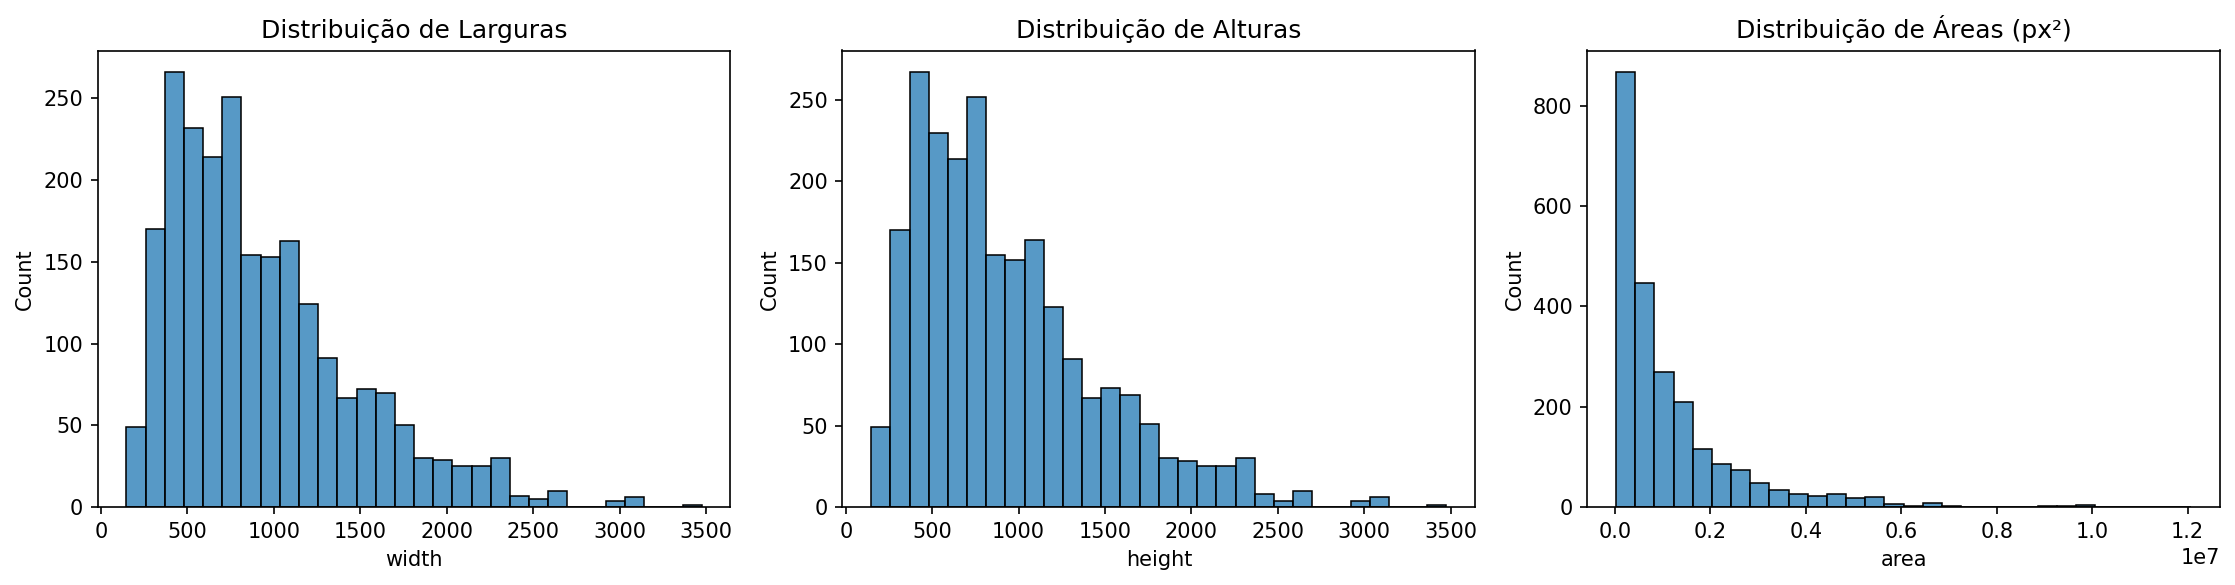

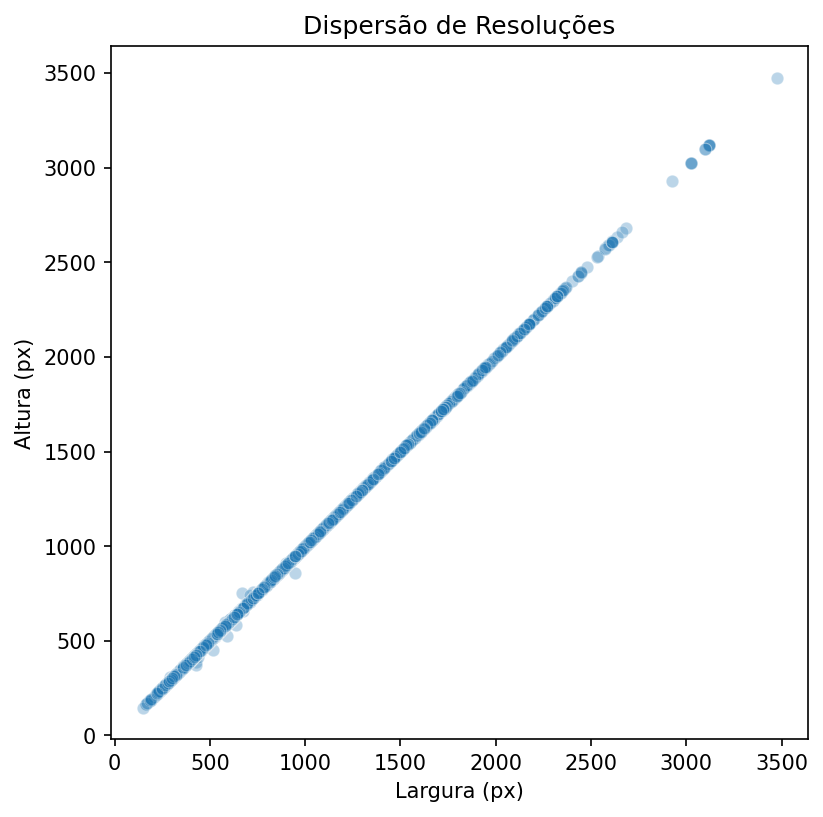

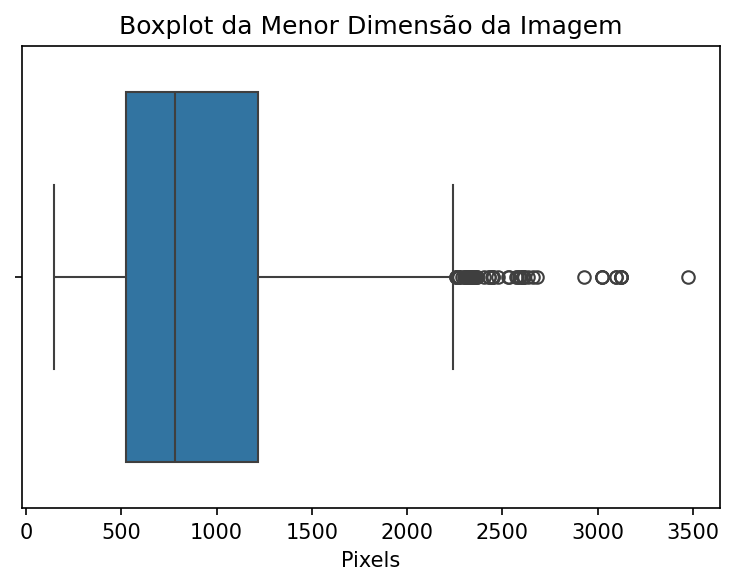

In [16]:
# 1 - caminho da base das imagens
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/UFES Pós IA CD/10. TCC/Dataset PAD-UFES-20/images/"

# 2 - extrair dimensões largura, altura, área)
widths, heights, areas = [], [], []

for img_id in tqdm(metadata['img_id'], desc="Lendo imagens"):
  try:
    with Image.open(os.path.join(DATA_PATH, img_id)) as img:
      w, h = img.size
      widths.append(w)
      heights.append(h)
      areas.append(w * h)
  except:
    widths.append(np.nan)
    heights.append(np.nan)
    areas.append(np.nan)

metadata["width"] = widths
metadata["height"] = heights
metadata["area"] = areas
metadata["aspect_ratio"] = metadata["width"] / metadata["height"]

# 3 - estatísticas gerais
summary = metadata[["width", "height", "area"]].describe().T
display(summary)

# 4 - histogramas
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.histplot(metadata["width"], bins=30, ax=axes[0])
axes[0].set_title("Distribuição de Larguras")
sns.histplot(metadata["height"], bins=30, ax=axes[1])
axes[1].set_title("Distribuição de Alturas")
sns.histplot(metadata["area"], bins=30, ax=axes[2])
axes[2].set_title("Distribuição de Áreas (px²)")
plt.tight_layout()
plt.show()

# 5 - scatter (largura x altura)
plt.figure(figsize=(6, 6))
sns.scatterplot(x="width", y="height", data=metadata, alpha=0.3)
plt.title("Dispersão de Resoluções")
plt.xlabel("Largura (px)")
plt.ylabel("Altura (px)")
plt.show()

# 6 - boxplot da menor dimensão
metadata["min_dim"] = metadata[["width", "height"]].min(axis=1)
plt.figure(figsize=(6, 4))
sns.boxplot(x="min_dim", data=metadata)
plt.title("Boxplot da Menor Dimensão da Imagem")
plt.xlabel("Pixels")
plt.show()

**Resoluções Típicas**
- Mediana ≈ 780 x 780 px (maioria em torno de 1MP).
- 75 % ≥ 1200 px (grande parte acima de 224 px seguro para CNNs padrão).
- Mínimo 147 px e poucos outliers > 3000 px (oriundos de diferentes smartphones).

**Aspect Ratio**
- Dispersão largura x altura perfeitamente linear (todas as imagens são quadradas ou quase. Aspect ratio ≈ 1).
- Isso permite *resize* direto sem distorção perceptível.

**Escolha da resolução-padrão**
- Pela distribuição e cauda longa, 224 x 224 px cobre mais de 90% dos casos mantendo amostra suficiente de detalhes.
- Alternativas válidas para testes:
  - 192 px se priorizar treino rápido.
  - 299 px se usar backbones Inception / EfficientNet.

**Outliers**
- Poucas imagens com lado menor que 256 px (descartar ou manter via *padding*).
- As muito grandes (maiores que 2500 px) podem ser redimensionadas sem perda relevante.

---

As imagens do PAD-UFES-20 apresentam mediana de ~780 px no menor lado, formato quadrado e grande variação de resolução (147 – 3476 px). Foi decidido adotar uma resolução-padrão de 224×224 px com resize + center-crop, suficiente para preservar detalhes e compatível com modelos CNN pré-treinados em ImageNet.


### 2.2. Formato de Cor (RGB vs escala de cinza)

In [18]:
# 1 - contar modos de cor (RGB, L, RGBA, etc)
color_modes = []
corrompidas = []

for img_id in tqdm(metadata['img_id'], desc="Verificando formato de cor"):
  try:
    with Image.open(os.path.join(DATA_PATH, img_id)) as img:
      color_modes.append(img.mode)
      corrompidas.append(img_id)
  except:
    color_modes.append("CORROMPIDA")
    corrompidas.append(img_id)

metadata["color_mode"] = color_modes

# 2 - frequência de modos de cor
mode_counts = pd.DataFrame.from_dict(Counter(color_modes), orient="index", columns=["count"])
mode_counts["percent"] = (mode_counts["count"] / len(metadata) * 100).round(2)
display(mode_counts)

# 3 - visualizar algumas amostras em cada modo de cor
for mode in mode_counts.index:
  sample = metadata[metadata["color_mode"] == mode].sample(1)
  img_path = os.path.join(DATA_PATH, sample.iloc[0]["img_id"])
  print(f"{mode}: {sample.iloc[0]['img_id']}")
  try:
    Image.open(img_path).show()
  except:
    print("Falha ao abrir imagem.")

Verificando formato de cor: 100%|██████████| 2298/2298 [00:08<00:00, 268.58it/s]


count  percent
RGB     858    37.34
RGBA   1440    62.66

RGB: PAT_419_833_148.png
RGBA: PAT_573_1090_660.png


Portanto,
- 62,7% das imagens estão em RGBA (com canal alfa).
- 37,3% em RGB.
- Nenhuma em grayscale ou corrompida.

O canal alfa provavelmente é transparente (adicionado pelo pipeline de exportação no PAD-UFES-20). **Para CNNs, o canal alfa deve ser removido**, pois redes pré-treinadas esperam exatamente 3 canais.

Das 2 298 imagens, 1 440 (62,7 %) estavam em modo RGBA e 858 (37,3 %) em RGB.
Nenhuma imagem estava em escala de cinza.
Todas serão convertidas para RGB (3 canais) para padronização de entrada nos modelos CNN.

In [19]:
# para execução posterior

# 4 - padronizando tudo para RGB antes do treino
def padronizar_rgb(img_path):
    img = Image.open(img_path)
    if img.mode == "RGBA":
        img = img.convert("RGB")
    return img

# 5 - atualização dos metadados
# metadata["color_mode_normalized"] = "RGB"

### 2.3. Verificação da integridade e qualidade das imagens

(verificação de duplicatas, brilho, foco e possíveis outliers)

Verificando integridade e qualidade: 100%|██████████| 2298/2298 [28:05<00:00,  1.36it/s]


patient_id  lesion_id  smoke  drink background_father background_mother  \
1924    PAT_419        833  False  False         POMERANIA         POMERANIA   
1087    PAT_419       2767  False  False         POMERANIA         POMERANIA   
1632    PAT_311        667   True  False             ITALY           GERMANY   
726     PAT_311        666   True  False             ITALY           GERMANY   
1498    PAT_570       1084  False  False         POMERANIA         POMERANIA   

      age pesticide  gender skin_cancer_history  ... diagnostic_group width  \
1924   80     False  FEMALE                True  ...           Cancer   750   
1087   80     False  FEMALE                True  ...           Benign   750   
1632   66     False  FEMALE               False  ...           Cancer   632   
726    66     False  FEMALE               False  ...           Cancer   632   
1498   43      True    MALE               False  ...           Cancer  1315   

     height     area aspect_ratio  min_dim  color_mode  \
1924    750   562500          1.0      750         RGB   
1087    750   562500          1.0      750         RGB   
1632    632   399424          1.0      632        RGBA   
726     632   399424          1.0      632        RGBA   
1498   1315  1729225          1.0     1315        RGBA   

                             file_hash  brightness   focus_var  
1924  08b2ef2acb959c289513972f44d3048c  134.198295  328.172789  
1087  08b2ef2acb959c289513972f44d3048c  134.198295  328.172789  
1632  0be5da1ded6ea8636bb9ca8f6aea5c06  119.453135  134.380814  
726   0be5da1ded6ea8636bb9ca8f6aea5c06  119.453135  134.380814  
1498  115ea17aa99c8b8744bc15154dd7414e  111.375549   70.901879  

[5 rows x 36 columns]

Número total de duplicatas exatas: 15


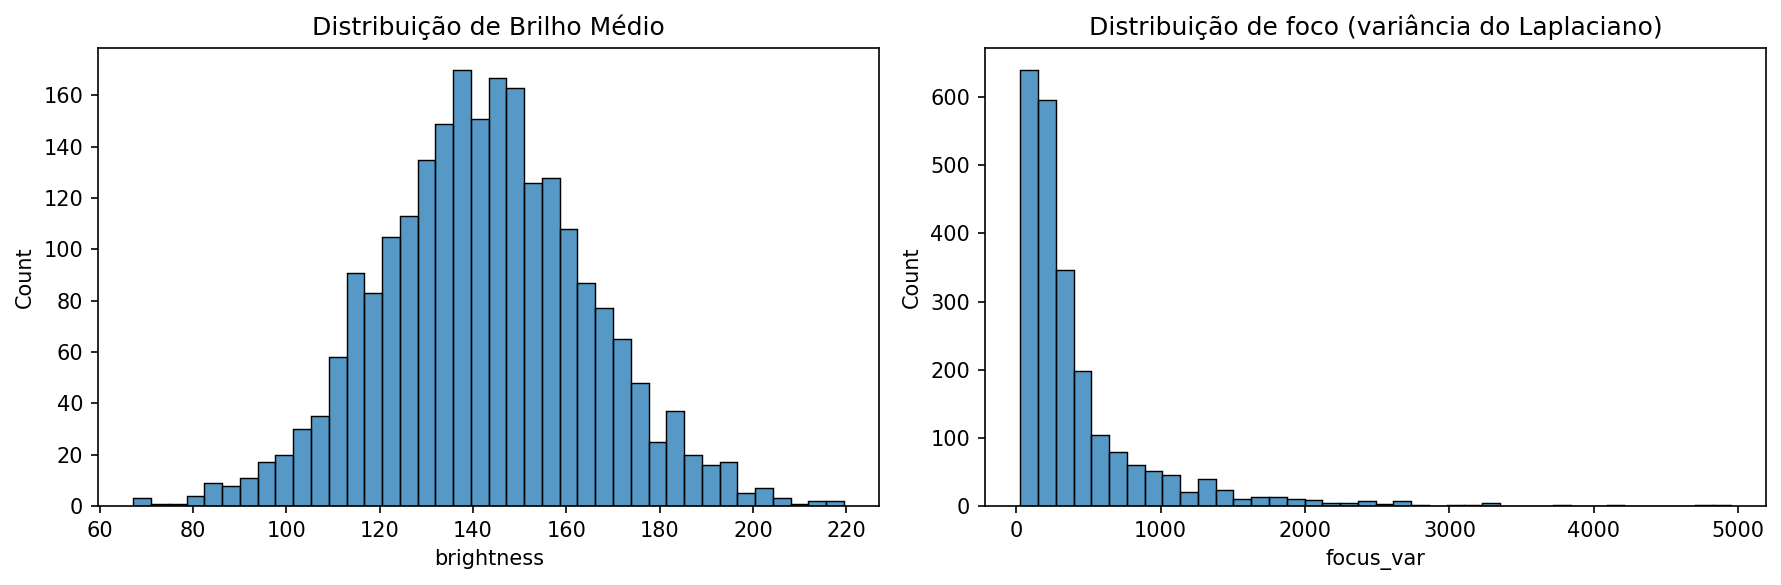

Imagens com baixa qualidade (brilho/foco extremos): 69


In [23]:
# 1 - funções auxiliares
def imagem_hash(img_path):
  """Hsh MD5 do conteúdo bruto (para detectar duplicatas exatas)"""
  try:
    with open(img_path, "rb") as f:
      return hashlib.md5(f.read()).hexdigest()
  except:
    return None


def metricas_imagem(img_path):
  """Extrai brilho (média) e foco (variâcia do Laplaciano)"""
  try:
    with Image.open(img_path) as img:
      img = img.convert("L") # escala de cinza para métricas
      stat = ImageStat.Stat(img)
      brilho = stat.mean[0]

      # foco = variância do Laplaciano (aproximação simples)
      lap = img.filter(ImageFilter.FIND_EDGES)
      foco = np.var(np.array(lap))
      return brilho, foco
  except:
    return np.nan, np.nan


# 2 - iterar sobre imagens
hashes, brights, focos = [], [], []
for img_id in tqdm(metadata['img_id'], desc="Verificando integridade e qualidade"):
  img_path = os.path.join(DATA_PATH, img_id)
  hashes.append(imagem_hash(img_path))
  b, f = metricas_imagem(img_path)
  brights.append(b)
  focos.append(f)

metadata["file_hash"] = hashes
metadata["brightness"] = brights
metadata["focus_var"] = focos


# 3 - duplicatas exatas
duplicatas = metadata[metadata.duplicated("file_hash", keep=False)].sort_values("file_hash")
display(duplicatas.head())

print(f"Número total de duplicatas exatas: {duplicatas['file_hash'].nunique()}")


# 4 - histogramas de brilho e foco
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(metadata["brightness"], bins=40, ax=axes[0])
axes[0].set_title("Distribuição de Brilho Médio")
sns.histplot(metadata["focus_var"], bins=40, ax=axes[1])
axes[1].set_title("Distribuição de foco (variância do Laplaciano)")
plt.tight_layout()
plt.show()


# 5 - marcar outliers (pouco foco ou briho extremo)
q_low_b, q_high_b = metadata["brightness"].quantile([0.01, 0.99])
q_low_f, q_high_f = metadata["focus_var"].quantile([0.01, 0.99])

metadata["low_quality"] = (
    (metadata["brightness"] < q_low_b)
    | (metadata["brightness"] > q_high_b)
    | (metadata["focus_var"] < q_low_f)
)

print(f"Imagens com baixa qualidade (brilho/foco extremos): {metadata['low_quality'].sum()}")

Foram detectadas 15 duplicatas exatas (0,65 % das amostras) e 69 imagens com brilho ou foco fora do intervalo 1–99 %. O restante das 2 298 amostras apresenta boa integridade e variabilidade realista de qualidade óptica, condizente com a natureza do dataset PAD-UFES-20.

- As duplicatas exatas (15 pares) devem ser removidas antes do treino, mantendo apenas uma por instância por `file_hash` (ou por `lesion_id`)
- Os outliers de baixa qualidade não devem ser descartados, mas sim marcados com `low_quality = True` para possível exclusão posterior e interferirem na performance do modelo.

In [27]:
metadata.to_csv("/content/drive/MyDrive/Colab Notebooks/UFES Pós IA CD/10. TCC/Dataset PAD-UFES-20/metadata_etapa23.csv")

### 2.4. Escolha da Resolução Padrão e Pré-Processamento de imagem

**Baseado na análise anterior**:
- Mediana do menor lado ≈ 780px.
- 75% das imagens maiores que 1200px (imagens grandes o bastante para resize seguro).
- Aspect ratio ≈ 1 (sem distorção relevante).
- Distribuição de foco/brilho adeqada, com apenas 3% de outliers.

---

**Recomendação de Escolha Técnica**:

| Parâmetro | Decisão | Justificativa |
| :---      | :---    | :---          |
| **Tamanho Final** | 224 x 224 px | Compatível com CNNs pré-treinadas (ResNet, DenseNet, MobileNet); cobre > 90% das imagens sem perda perceptível |
| **Alternativa Opcional** | 299 x 299 px | Para testes com Inception/EfficientNet B3 |
| **Conversão de Cor** | RGBA -> RGB (3 canais) | Uniformizar entrada |
| **Normalização** | `pixel / 255.0`, depois `normalize(mean, std)` para canal | Segue padrão ImageNet; ajuda na convergência |
| **Resize policy** | `resize (min_side=256) -> center-crop 224` | Mantém proporções e centraliza lesão |
| **Aumento de dados** | flips horizontais, rotações ±10°, leve jitter com brilho/contraste (±0.1) | Simula variação de captura sem alterar o padrão clínico |
| **Marcação de baixa qualidade** | manter(`low_quality=True`) | Garante representatividade: pode ser filtrado depois |

---

**Exemplo de pré-processamento (PyTorch-style)**:

In [ ]:
from torchvision import transforms

train_tfms = transforms.Compose([

    # converte para grayscale mas mantém 3 canais
    # transforms.Grayscale(num_output_channels=3), # para versão grayscale

    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

**Redimensionamento e conversão para RGB**
Imagens salvas em um novo diretório `images_resize`

In [31]:
# Caminhos
SRC_PATH = "/content/drive/MyDrive/Colab Notebooks/UFES Pós IA CD/10. TCC/Dataset PAD-UFES-20/images/"
DST_PATH = "/content/drive/MyDrive/Colab Notebooks/UFES Pós IA CD/10. TCC/Dataset PAD-UFES-20/images_resize/"

os.makedirs(DST_PATH, exist_ok=True)

# transformação
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224)
])

# Funçao de Conversão e Redimensinamento
def processar_imagem(src, dst, size=(224, 224)):
  try:
    with Image.open(src) as img:
      # converter RGBA -> RGB se necessário
      if img.mode != "RGB":
        img = img.convert("RGB")
      # redimensionar mantendo proporção (menor lado = size[0]) e crop central
      img = transform(img)
      img.save(dst, format="PNG")
      return True
  except Exception as e:
    return False


# Loop Principal
falhas = []
for img_id in tqdm(metadata['img_id'], desc="Convertendo e redimensionando imagens"):
  src = os.path.join(SRC_PATH, img_id)
  dst = os.path.join(DST_PATH, img_id)
  ok = processar_imagem(src, dst)
  if not ok:
    falhas.append(img_id)

print(f"\nConversão concluída. Imagens com erro: {len(falhas)}")
if falhas:
  print(falhas[:10])

Convertendo e redimensionando imagens: 100%|██████████| 2298/2298 [03:55<00:00,  9.75it/s]


Conversão concluída. Imagens com erro: 0


## 3. Balanceamento, Normalização e Augmentação

 - Há desequilíbrio forte entre classes?
    - Definir augmentação com base nas imperfeições reais:
        - flip horizontal/vertical (avaliar sentido clínico),
        leve rotation, crop, lighting jitter controlado,
        blur moderado se houver desfoque real.
    - Evitar augmentação artificial exagerada (distorta padrão clínico).
    - dica de gráfico: mostrar umas imagens aumentadas, pra mostrar o que o augmentation fez

  ---

  Objetivo: definir como mitigar desbalanceamento e qual augmentação é realista.

1. **Desbalanceamento**

- O que: curva de Pareto das classes; tabela com baseline “acurácia sempre-classe-majoritária” e acurácia balanceada teórica se previsse ao acaso por proporções.

- Decisões:

  - Ponderação de perda (inverse freq) como default;

  - Oversampling de classes raras no DataLoader ou class-balanced sampler;

  - Evite heavy oversampling de MEL se muito escasso; combine com aug fraca-moderada.

2. **Normalização**

- RGB: calcule média/desvio por canal no treino (após resize), documente.

- Grayscale: calcule média/desvio únicos (ou use [0.5, 0.5, 0.5] ao replicar canal, mas registre a opção).

3. **Augmentação alinhada ao dado**

- Base segura:

  - flip horizontal (avaliar implicações de lateralidade anatômica; em geral ok);

  - rotação pequena (±10–15°);

  - random-resized-crop (zoom levemente > 1, p.ex. scale [0.9, 1.1]);

  - jitter leve (brilho/contraste 0.1–0.2);

  - blur leve (p≈0.1) se há desfoque no real.

- Evitar: distorções geométricas fortes, hue shifts agressivos, cortes que removam a lesão.

- Gráfico sugerido: grid 3×4 com 3–4 imagens originais e suas versões aumentadas (mesmos parâmetros que serão usados no treino).

---

Saídas: plano de balanceamento (loss weights/oversampling), estatísticas de normalização, grid de augmentations e uma nota de “o que ficou de fora e por quê”.

### 3.1 Análise de Desbalanceamento e Decisão de Estratégias de Correção

diagnostic  count  percent  cum_percent
0        BCC    845    36.77    36.771105
1        ACK    730    31.77    68.537859
2        NEV    244    10.62    79.155788
3        SEK    235    10.23    89.382071
4        SCC    192     8.36    97.737163
5        MEL     52     2.26   100.000000

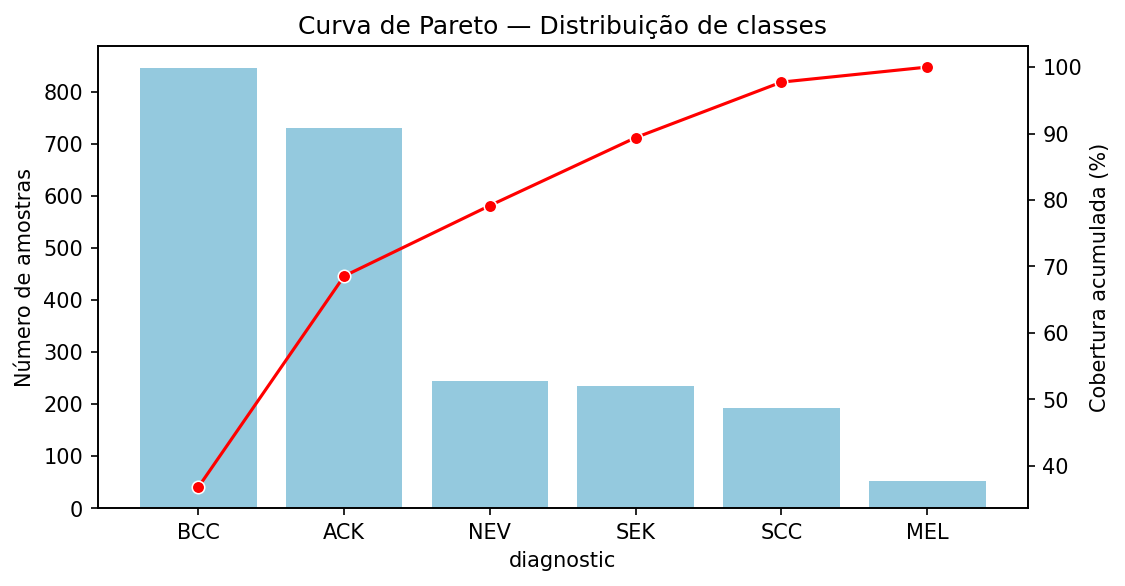

Baseline  Acurácia esperada
0  Sempre-classe-majoritária              0.368
1     Aleatória proporcional              0.265
2           Balanceada ideal              0.167

diagnostic  weight
0        BCC   0.453
1        ACK   0.525
2        NEV   1.570
3        SEK   1.630
4        SCC   1.995
5        MEL   7.365

In [33]:
# 1 - contagem e proporção das classes
class_counts = metadata["diagnostic"].value_counts().reset_index()
class_counts.columns = ["diagnostic", "count"]
class_counts["percent"] = (class_counts["count"] / class_counts["count"].sum() * 100).round(2)
class_counts["cum_percent"] = class_counts["count"].cumsum() / class_counts["count"].sum() * 100

display(class_counts)

# 2 - curva de Pareto
fig, ax1 = plt.subplots(figsize=(8, 4))
sns.barplot(data=class_counts, x="diagnostic", y="count", color="skyblue", ax=ax1)
ax1.set_ylabel("Número de amostras")

ax2 = ax1.twinx()
sns.lineplot(data=class_counts, x="diagnostic", y="cum_percent", color="red", marker="o", ax=ax2)
ax2.set_ylabel("Cobertura acumulada (%)")

plt.title("Curva de Pareto — Distribuição de classes")
plt.show()

# 3 - baselines teóricos
n_classes = len(class_counts)
total = class_counts["count"].sum()
major_class_acc = class_counts["count"].max() / total  # sempre prever a classe majoritária
random_acc = sum((class_counts["count"]/total)**2)     # prever ao acaso proporcionalmente às frequências
balanced_acc = 1 / n_classes                           # acurácia balanceada ideal (todas iguais)

baseline_table = pd.DataFrame({
    "Baseline": ["Sempre-classe-majoritária", "Aleatória proporcional", "Balanceada ideal"],
    "Acurácia esperada": [major_class_acc, random_acc, balanced_acc]
}).round(3)

display(baseline_table)

# 4 - pesos inversos por classe (para uso em loss)
class_weights = total / (n_classes * class_counts["count"])
display(pd.DataFrame({
    "diagnostic": class_counts["diagnostic"],
    "weight": class_weights.round(3)
}))


- **Baselines teóricos**: 0.368 se o modelo só prever "BCC", 0.265 sendo o acerto médio de um classificador aleatório, e 0.167 de acurácia se todas as classes tiverem peso igual.
- Os **pesos inversos** podem ser aplicados diretamente em `CrossEntropyLoss(weight=class_weights)` no PyTorch. Portanto, obrigatória uma Loss ponderada pelos pesos inversos.
- **Oversampling leve** para `MEL` e `SCC` (duplicar não mais que 2 ou 3x)
- **Data augmentation moderada** para `MEL` (rotação +/-10º, flip, brightness jitter leve)
- **Sem undersampling** das classes grandes (manter representatividade).

### 3.2. Normalização RGB (Cálculo da Média e Desvio Padrão por Canal)

In [38]:
# caminho imagens redimensionadas
DATA_RESIZED = "/content/drive/MyDrive/Colab Notebooks/UFES Pós IA CD/10. TCC/Dataset PAD-UFES-20/images_resize/"

# função de cálculo incremental de média e desvio por canal
def calcular_media_std_rgb(image_paths):
  n_pixels_total = 0
  soma = np.zeros(3)
  soma_quadrado = np.zeros(3)

  for path in tqdm(image_paths, desc="Calculando média/desvio por canal"):
    with Image.open(path) as img:
      img = img.convert("RGB")
      arr = np.array(img, dtype=np.float32) / 255.0 # normaliza [0,1]
      n_pixels = arr.shape[0] * arr.shape[1]
      n_pixels_total += n_pixels
      soma += arr.reshape(-1, 3).sum(axis=0)
      soma_quadrado += (arr.reshape(-1, 3) ** 2).sum(axis=0)

  mean = soma / n_pixels_total
  std = np.sqrt(soma_quadrado / n_pixels_total - mean ** 2)
  return mean, std

# executar calculo sobre todas as imagens redimensionadas
image_files = [os.path.join(DATA_RESIZED, f) for f in os.listdir(DATA_RESIZED) if f.endswith(".png")]

mean, std = calcular_media_std_rgb(image_files)

print("\nMédias por canal (R, G, B):", np.round(mean, 4))
print("Desvios-padrão por canal (R, G, B):", np.round(std, 4))

Caculando média/desvio por canal: 100%|██████████| 2298/2298 [00:23<00:00, 98.02it/s] 

Médias por canal (R, G, B): [0.6641 0.5185 0.4603]
Desvios-padrão por canal (R, G, B): [0.1411 0.1402 0.1463]


Parâmetros finais para o Pipeline de treino:

```python
from torchvision import transforms

train_tfms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.6641, 0.5185, 0.4603],
                         std=[0.1411, 0.1402, 0.1463])
])
```

### 3.3. Particionamento

## 4. Particionamento

- Garantir split por paciente, não por imagem.
    - Train/val/test estratificado por paciente.
    - Teste totalmente separado e estável desde o início.
        - apresentar gráfico ou tabela provando que seus conjuntos de split estão balanceados por classe

  ---

Objetivo: splits reprodutíveis, sem vazamento e com equilíbrio razoável.

1. **Unidade de split**

- Regra: todas as imagens do mesmo patient_id ficam no mesmo conjunto.

- Se um paciente tem múltiplas lesões com rótulos distintos, ainda assim agrupe por paciente (é o mais conservador contra vazamento). Registre essa decisão.

2. **Estratificação por classe (nível paciente)**

- Procedimento:

  - Agregue por patient_id → defina um rótulo de estratificação: pode ser “classe principal” (a classe mais frequente do paciente) ou vetor multi-hot (quando possível usar métodos estratificados multi-rótulo).

  - Faça train/val/test (ex.: 70/15/15) estratificado por paciente.

  - Fixe seeds e salve os IDs dos pacientes por split (artefato versionado).

3. **Teste estável desde o início**

- Congele test na primeira execução e nunca o toque. Use só train/val para iteração.

4. **Provas de equilíbrio e de não-vazamento**

- Tabelas:

  - Distribuição de classes por split (contagem e %).

  - Distribuição de biopsed por split.

  - Faixa etária e region por split (opcional, para mostrar comparabilidade).

- Checks automáticos:

  - Interseção de patient_id entre splits = ∅.

  - Interseção de lesion_id entre splits = ∅ (opcional e desejável).

  - Para cada classe, diferença absoluta de proporção entre splits ≤ limite (ex.: 3–5 p.p.). Se exceder, refaça amostragem estratificada.

Saídas: arquivos splits/ com patients_train.txt, patients_val.txt, patients_test.txt; tabelas/gráficos de equilíbrio; checklist de vazamento zerado.